## Import packages and initial DataFrame

In [1]:
import pandas as pds
import numpy as np
import textdistance
import timeit
import math
import statsmodels.api as sm
import scipy
from patsy import dmatrix
import time
import math
import tqdm
import os
import seaborn as sns
from random import choices
from matplotlib import pyplot as plt

name_DF = 'DF_N=4401_2023-01-16.csv'
DF = pds.read_csv(os.path.join('..', 'datasets', name_DF), delimiter = ',')
DF = DF[~DF.duplicated()] # delete duplicates
DF = DF.dropna() # delete NaN values
DF['was_assigned_female'] = DF['was_assigned_female'].astype('int32') # turn was_born_female into int type (once Nan values have been removed)

identifiers = {'family_name':'jaro-winkler','was_assigned_female':'strict','country':'strict','birth_year':'large'}
covariates = ['X1','X2','X3','X4','X5']

## Generate covariates, treatment and associations with outcome

In [2]:
# generate covariates
DF['X1'] = 2020 - DF['birth_year'] # age
DF['X2'] = np.random.normal(loc = 2.5, scale = 1, size = DF.shape[0])
DF['X3'] = np.random.normal(loc = 0, scale = 1, size = DF.shape[0])
DF['X4'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])
DF['X5'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])

# generate treatment
DF['treatment'] = np.random.binomial(n = 1, p = 1 / ( 1 + np.exp(0.1*DF.X1 -0.2*DF.X2 +0.3*DF.X3 -0.4*DF.X4 +0.5*DF.X5) )) # probability depending on covariates

# generate outcome
residual_errors = np.random.normal(size = DF.shape[0])
a = 5.5
b = 0.01
c = 0.08
d = 0.7

ate = a * 2.5
DF['Y'] = - 10 + a*DF['treatment']*DF['X2'] + b*np.exp(DF['X4']) + c*DF['X3']*DF['X1'] + d*DF['X5'] 

## Generate subdatasets A and B with common records

In [3]:
common_records = DF.sample(n = 800)

B = pds.concat([DF.sample(n = 1400), common_records]).drop(['Y'], axis = 1)
B = B.reset_index(drop=True)

A = pds.concat([DF.sample(n = 2000), common_records])[list(identifiers.keys())+['Y']]
A = A.reset_index(drop=True)

## Write fucntions to compare linking variables among records
- Levenshtein similarity
- Jaro Winkler similarity
- Strict equality
- Large equality

In [4]:
def levenshtein_similarity(a,b):

    """ Check that levenshtein similarity (in [0,1]) is above 0.95.
        
        a: string,
        b: string """

    if 1 - textdistance.levenshtein(a, b)/max(len(a),len(b)) >= 0.95:
        return 1
    else:
        return 0

def jaro_winkler_similarity(a,b):

    """ Check that jaro-winkler similarity (in [0,1]) is above 0.95.
        
        a: string,
        b: string """

    if textdistance.jaro_winkler(a,b) >= 0.99:
        return 1
    else:
        return 0

def strict_equality(a,b):

    """ Check that a and b values are equal.
        
        a: any value,
        b: any value """

    return a==b

def large_equality(a,b):

    """ Check that years a and b expressed with four numbers are within the same decade.
        
        a: year,
        b: year """

    return str(a)[:-1]==str(b)[:-1]

## Write fucntions to compute the propensity score estimates based on covariates in a DataFrame

In [5]:
def logit(p):
    return np.log(p/(1-p))

def minmaxscaler(X):
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    
def propensity_score(DF, covariates, scaler, convert_to_logit):
    
    """ Compute propensity score estimates: the probability (logistic regression) that an observation is treated or not conditioned on some covariates.
        These estimates are built conditionaly on covariates passed using a logit after transformation by scaler (when one is specified).
        Estimated probabilities can be converted into logit (convert_to_logit parameter).

        DF:                dataframe,
        covariates:        list of strings for covariates variable in DF,
        scaler:            sklearn.preprocessing function scaler for exemple,
        convert_to_logit:  boolean for converting probabilities to logit when building the propensity score estimates based on a logistic regression
    """
    exog = np.array(DF[covariates])
    if scaler != None:
        exog = scaler(exog)
    intercept = np.ones(DF.shape[0]).reshape(-1,1)
    exog = np.concatenate((exog, intercept), axis=1)
    model = sm.Logit(DF.treatment, exog).fit(disp=0)
    predictions = model.predict(exog)
    if convert_to_logit:
        return logit(predictions)
    else: 
        return predictions

## Compute the cartesian product of all records in A and B
- add the source index (in A or B)
- add the linking score for each pair of records
- compute comparison vectors
- compute the probability of having same linking variables (at all and for matches)

In [6]:
AB = B.merge(A, how='cross', suffixes=("_B", "_A")) # preserve order of left keys: B file
AB["source_index_B"] = np.repeat(B.index, A.shape[0])
AB["source_index_A"] = np.tile(A.index, B.shape[0])

methods = {'jaro-winkler':jaro_winkler_similarity, 'levenshtein':levenshtein_similarity, 'strict':strict_equality, 'large':large_equality}

for linking_var in identifiers.keys():
    method = methods[identifiers[linking_var]]
    df = AB.filter(regex=linking_var)
    AB[linking_var+"_comparison"] = np.array([method(a, b) for a,b in zip(df.iloc[:,0], df.iloc[:,1])]).astype(int).reshape(-1,1)

comparison_vectors_only = AB.filter(regex="comparison")

unmatch = np.array(comparison_vectors_only.sum(axis=0) / len(comparison_vectors_only)) # probability of having same linking var (at all)
match = np.repeat(0.95, len(identifiers.keys())) # probability of having same linking var when being matches

AB["linking_score"] = (np.multiply(comparison_vectors_only, np.log2(match/unmatch)) + np.multiply(1-comparison_vectors_only, np.log2((1-match)/(1-unmatch)))).sum(axis=1)
# AB['propensity_score'] = propensity_score(AB, covariates, None, False) CA N A PAS DE SENS !!!

AB

,name,family_name_B,country_B,birth_year_B,was_assigned_female_B,X1,X2,X3,X4,X5,...,country_A,birth_year_A,Y,source_index_B,source_index_A,family_name_comparison,was_assigned_female_comparison,country_comparison,birth_year_comparison,linking_score
0,Raik,Gennerich,DE,2003,0,17,3.576932,-0.020607,1.793694,1.196956,...,AT,1964,-13.533736,0,0,0,0,0,0,-15.889818
1,Raik,Gennerich,DE,2003,0,17,3.576932,-0.020607,1.793694,1.196956,...,RU,1976,-6.342572,0,1,0,0,0,0,-15.889818
2,Raik,Gennerich,DE,2003,0,17,3.576932,-0.020607,1.793694,1.196956,...,RU,2018,-9.196387,0,2,0,0,0,0,-15.889818
3,Raik,Gennerich,DE,2003,0,17,3.576932,-0.020607,1.793694,1.196956,...,FR,2017,-1.716659,0,3,0,0,0,0,-15.889818
4,Raik,Gennerich,DE,2003,0,17,3.576932,-0.020607,1.793694,1.196956,...,RU,1998,-11.887771,0,4,0,1,0,0,-11.647624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6159995,Rüdiger,Schäfer,DE,2003,0,17,2.759183,0.281329,-0.261563,1.991355,...,DE,1955,-5.603823,2199,2795,0,0,1,0,-8.625443
6159996,Rüdiger,Schäfer,DE,2003,0,17,2.759183,0.281329,-0.261563,1.991355,...,DE,1995,-11.797470,2199,2796,0,0,1,0,-8.625443
6159997,Rüdiger,Schäfer,DE,2003,0,17,2.759183,0.281329,-0.261563,1.991355,...,RU,1998,-8.949982,2199,2797,0,0,0,0,-15.889818
6159998,Rüdiger,Schäfer,DE,2003,0,17,2.759183,0.281329,-0.261563,1.991355,...,FI,1986,-5.251760,2199,2798,0,1,0,0,-11.647624


In [7]:
comparison_vectors_only

,family_name_comparison,was_assigned_female_comparison,country_comparison,birth_year_comparison
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,1,0,0
...,...,...,...,...
6159995,0,0,1,0
6159996,0,0,1,0
6159997,0,0,0,0
6159998,0,1,0,0


## Build the initial linkage
- find perfect comparisons between linking variables
- remove duplicates coming from A or from B
- on linked records, compute the propensity score
- build z0 the initial linkage estimates
- compute the true linkage (based on the common records subdataset built at the start)

For each record in $B$ we find the best match in $A$

Produce the linkage variable $$z_j = \left\{
    \begin{array}{ll}
        i & \text{if } \{i,j\} \text{ are matched} \\
        j + n_A & \text{otherwise.}
    \end{array}
\right.$$

In [8]:
where_good_comparisons = AB[comparison_vectors_only.all(axis=1)]

# remove duplicata: 
where_good_comparisons = where_good_comparisons[ (~where_good_comparisons.source_index_A.duplicated(keep=False)) & (~where_good_comparisons.source_index_B.duplicated(keep=False)) ]

idx_A = where_good_comparisons.source_index_A
idx_B = where_good_comparisons.source_index_B

# from_A = A.iloc[idx_A,:].reset_index(drop=True)
# from_B = B.iloc[idx_B,:].reset_index(drop=True)

# linked_records = pds.concat([from_B, from_A.Y], axis=1)
# linked_records['propensity_score'] = propensity_score(linked_records, covariates, None, False)

z_init = -np.ones(B.shape[0])
z_init[idx_B] = idx_A

true_linkage_z = -np.ones(B.shape[0])
true_linkage_z[B.iloc[-800:,:].index] = A.iloc[-800:,:].index

Because the linkage estimate is built by removing duplicates from A and B to enforce 1-2-1 matching we miss some matches and make some errors. We evaluate the proportion of good estimations below:

In [9]:
(z_init == true_linkage_z).sum() / len(true_linkage_z)

0.5068181818181818

## Use full conditional distributions to draw each new estimate

### Update probability of having same linking variables (at all and for matches):

In [15]:
# NEED:

previous_z = z0.copy()
a = 1
b = 1
comparison_vectors = comparison_vectors_only.copy()
cartesian_product_AB = AB.copy()

In [16]:
idx_match_A = previous_z[previous_z>=0]
idx_match_B = np.nonzero(previous_z>=0)[0]
links = pds.MultiIndex.from_tuples(zip(idx_match_A,idx_match_B))
pairs = pds.MultiIndex.from_frame(cartesian_product_AB[["source_index_A", "source_index_B"]])

# UPDATE PROBA OF SAME LINKING VARIABLE FOR UNMATCH:

comparison_vectors_for_non_matches = comparison_vectors[~pairs.isin(links)]
new_theta_u = scipy.stats.beta.rvs(comparison_vectors_for_non_matches.sum(axis=0) + a, (1-comparison_vectors_for_non_matches).sum(axis=0) + b)


# UPDATE PROBA OF SAME LINKING VARIABLE FOR MATCH:

comparison_vectors_for_matches = comparison_vectors[pairs.isin(links)]
new_theta_m = scipy.stats.beta.rvs(comparison_vectors_for_matches.sum(axis=0) + a, (1-comparison_vectors_for_matches).sum(axis=0) + b)

new_theta_u, new_theta_m

(array([2.56723984e-04, 5.00357671e-01, 1.09429133e-01, 1.44138548e-01]),
 array([0.9970143 , 0.99985417, 0.99979387, 0.99979615]))

REMARK: 
- tres petit car considere tous les liens, peut etre a recalculer sur les non liens avec filtres sur les duplicata?
- tres grand car considere que des liens avec des perfect comparison vectors

### Update regression coefficients estimates for parametric outcome regression (matches distribution)

In [10]:
# NEED:

previous_z = z0.copy()
cartesian_product_AB = AB.copy()
previous_a_sigma = 1
previous_b_sigma = 1
previous_beta0, previous_beta1, previous_alpha = scipy.stats.multivariate_normal.rvs(np.array([0,0,0]), np.eye(3))

In [11]:
idx_match_A = previous_z[previous_z>=0]
idx_match_B = np.nonzero(previous_z>=0)[0]
links = pds.MultiIndex.from_tuples(zip(idx_match_A,idx_match_B))
pairs = pds.MultiIndex.from_frame(cartesian_product_AB[["source_index_A", "source_index_B"]])

# UPDATE COEFFICIENTS betas, alpha, sigma^2

data_for_matches = cartesian_product_AB[pairs.isin(links)]
 
outcome_for_matches =  np.array(data_for_matches.Y)
treatment_for_matches =  np.array(data_for_matches.treatment)
linked_records_propensity_score = propensity_score(data_for_matches, covariates, None, False)
interaction_term = treatment_for_matches * linked_records_propensity_score

K = np.concatenate([np.ones(len(outcome_for_matches)).reshape(-1,1), linked_records_propensity_score.reshape(-1,1), interaction_term.reshape(-1,1)], axis=1)

n_AB = sum(previous_z>=0)
new_sigma_square = scipy.stats.invgauss.rvs(previous_a_sigma + n_AB/2, np.linalg.norm(outcome_for_matches - K @ np.array([previous_beta0, previous_beta1, previous_alpha]))**2 / 2 + previous_b_sigma)
 
Sigma_beta = np.linalg.inv( (K.T @ K)/new_sigma_square + np.eye(3) )
mu_beta = Sigma_beta @ (K.T @ outcome_for_matches)/new_sigma_square

new_beta0, new_beta1, new_alpha = scipy.stats.multivariate_normal.rvs(mu_beta, Sigma_beta)

### Update regression coefficients estimates for gaussian (non matches distribution)

In [12]:
# NEED:

previous_z = z0.copy()
cartesian_product_AB = AB.copy()
previous_mu2 = scipy.stats.norm.rvs(0, 1)
previous_a_sigma2 = 1
previous_b_sigma2 = 1

In [13]:
# UPDATE sigma2^2 and mu2
 
idx_match_A = previous_z[previous_z>=0]
idx_match_B = np.nonzero(previous_z>=0)[0]
links = pds.MultiIndex.from_tuples(zip(idx_match_A,idx_match_B))
pairs = pds.MultiIndex.from_frame(cartesian_product_AB[["source_index_A", "source_index_B"]])

data_for_non_matches = cartesian_product_AB[~pairs.isin(links)]

outcome_for_non_matches =  np.array(data_for_non_matches.Y)

n_AB = sum(previous_z>=0)
new_sigma2_square = scipy.stats.invgauss.rvs(previous_a_sigma2 + (A.shape[0] - n_AB)/2, previous_b_sigma2 + sum((outcome_for_non_matches - previous_mu2)**2)/2)
sigma_mu2_square = 1/((A.shape[0] - n_AB)/new_sigma2_square + 1)
m_mu2 = sigma_mu2_square * (outcome_for_non_matches).sum() / new_sigma2_square
new_mu2 = scipy.stats.norm.rvs(m_mu2, sigma_mu2_square)

### Update linkage variable

In [17]:
# NEED:

# previous_z = z0.copy()
cartesian_product_AB = AB.copy()
comparison_vectors = comparison_vectors_only.copy()
previous_theta_u = new_theta_u.copy()
previous_theta_m = new_theta_m.copy()
previous_beta0 = new_beta0.copy()
previous_beta1 = new_beta1.copy()
previous_alpha = new_alpha.copy()
previous_mu2 = new_mu2.copy()
previous_sigma2_square = new_sigma2_square.copy()
previous_z = z0.copy()
previous_beta_pi = 1
previous_alpha_pi = 1

In [39]:
# UPDATE z

# for all (q,j) pair of records
w1 = ( np.multiply( comparison_vectors, np.log(previous_theta_m/previous_theta_u) ) + np.multiply( 1-comparison_vectors, np.log((1-previous_theta_m)/(1-previous_theta_u)) ) ).sum(axis=1)

# for all (q,j) pair of records
intercept = np.ones(cartesian_product_AB.shape[0])
records_treatment =  np.array(cartesian_product_AB.treatment)
records_propensity_score = propensity_score(cartesian_product_AB, covariates, None, False)
interaction_term = records_treatment * records_propensity_score

X = np.concatenate([intercept.reshape(-1,1), records_propensity_score.reshape(-1,1), interaction_term.reshape(-1,1)], axis=1)
Betas = np.array([previous_beta0, previous_beta1, previous_alpha])
residuals = cartesian_product_AB.Y - X @ Betas.T

estimated_variance = residuals.T @ residuals / (len(residuals) - (X.shape[1]+1))

distr_linked_outcomes = scipy.stats.norm.pdf(residuals, 0, np.sqrt(estimated_variance))
distr_non_linked_outcomes = scipy.stats.norm.pdf(cartesian_product_AB.Y, previous_mu2, np.sqrt(previous_sigma2_square))
w2 = np.log(distr_linked_outcomes / distr_non_linked_outcomes)

probabilities = np.array(np.exp(w1 + w2)) # for all (q,j) pairs
probabilities = probabilities.reshape(B.shape[0], A.shape[0])

n_AB_ = np.array([ (np.delete(previous_z, j)>=0).sum() for j in range(B.shape[0]) ])
proba_for_unmatch = (A.shape[0] - n_AB_) * (B.shape[0] - n_AB_ - 1 + previous_beta_pi) / (n_AB_ + previous_alpha_pi) # for all j
probabilities = np.concatenate([probabilities, proba_for_unmatch.reshape(-1,1)], axis=1)

probabilities = np.divide(probabilities.T, probabilities.sum(axis=1)).T # j in row, all A index value + -1 in column

sns.heatmap(probabilities)
plt.show()

sns.heatmap(probabilities[:,2799:])
plt.show()


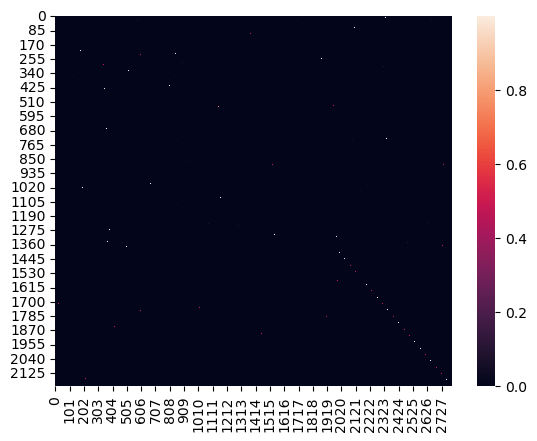

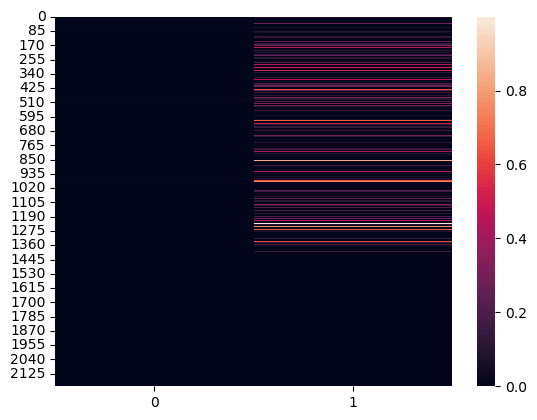

In [71]:
# UPDATE z

# for all (q,j) pair of records
w1 = ( np.multiply( comparison_vectors, np.log(previous_theta_m/previous_theta_u) ) + np.multiply( 1-comparison_vectors, np.log((1-previous_theta_m)/(1-previous_theta_u)) ) ).sum(axis=1)

# for all (q,j) pair of records
intercept = np.ones(cartesian_product_AB.shape[0])
records_treatment =  np.array(cartesian_product_AB.treatment)
records_propensity_score = propensity_score(cartesian_product_AB, covariates, None, False)
interaction_term = records_treatment * records_propensity_score

X = np.concatenate([intercept.reshape(-1,1), records_propensity_score.reshape(-1,1), interaction_term.reshape(-1,1)], axis=1)
Betas = np.array([previous_beta0, previous_beta1, previous_alpha])
residuals = cartesian_product_AB.Y - X @ Betas.T

estimated_variance = residuals.T @ residuals / (len(residuals) - (X.shape[1]+1))

distr_linked_outcomes = scipy.stats.norm.pdf(residuals, 0, np.sqrt(estimated_variance))
distr_non_linked_outcomes = scipy.stats.norm.pdf(cartesian_product_AB.Y, previous_mu2, np.sqrt(previous_sigma2_square))
w2 = np.log(distr_linked_outcomes / distr_non_linked_outcomes)

probabilities = np.array(np.exp(w1 + w2)) # for all (q,j) pairs
probabilities = probabilities.reshape(B.shape[0], A.shape[0])

n_AB_ = np.array([ (np.delete(previous_z, j)>=0).sum() for j in range(B.shape[0]) ])
proba_for_unmatch = (A.shape[0] - n_AB_) * (B.shape[0] - n_AB_ - 1 + previous_beta_pi) / (n_AB_ + previous_alpha_pi) # for all j

# probabilities_to_print = np.concatenate([probabilities, proba_for_unmatch.reshape(-1,1)], axis=1)

# probabilities_to_print = np.divide(probabilities_to_print.T, probabilities_to_print.sum(axis=1)).T # j in row, all A index value + -1 in column

# sns.heatmap(probabilities_to_print)
# plt.show()

# sns.heatmap(probabilities_to_print[:,2799:])
# plt.show()

In [74]:
new_z = []
taken = np.array([])

for j in range(B.shape[0]):
    
    possible_values = list(set(np.arange(A.shape[0])) - set(taken))

    proba = list(probabilities[j,:][possible_values])
    
    possible_values.append(-1)
    proba.append(proba_for_unmatch[j])

    val = choices(possible_values, weights = proba)[0]
    if val != -1:
        taken = np.append(taken, val)

    new_z.append(val)

In [ ]:
# def update_theta(comparison_vectors, links, pairs, previous_a, previous_b, previous_beta0, previous_beta1, previous_alpha):
#             comparison_vectors_for_non_matches = comparison_vectors[~pairs.isin(links)]
#             comparison_vectors_for_non_matches_sum = comparison_vectors_for_non_matches.sum(axis=0)
#             new_theta_u = scipy.stats.beta.rvs(comparison_vectors_for_non_matches_sum + previous_a, comparison_vectors_for_non_matches.shape[0] - comparison_vectors_for_non_matches_sum + previous_b)
#             comparison_vectors_for_matches = comparison_vectors[pairs.isin(links)]
#             comparison_vectors_for_matches_sum = comparison_vectors_for_matches.sum(axis=0)
#             new_theta_m = scipy.stats.beta.rvs(comparison_vectors_for_matches_sum  + previous_a, comparison_vectors_for_matches.shape[0] - comparison_vectors_for_matches_sum + previous_b)
#             return new_theta_u, new_theta_m

In [22]:
def update_theta(comparison_vectors, links, pairs, previous_a, previous_b, previous_beta0, previous_beta1, previous_alpha):
    #comparison_vectors_for_non_matches = comparison_vectors[~pairs.isin(links)]
    #new_theta_u = scipy.stats.beta.rvs(comparison_vectors_for_non_matches.sum(axis=0) + previous_a, (1-comparison_vectors_for_non_matches).sum(axis=0) + previous_b)
    #comparison_vectors_for_matches = comparison_vectors[pairs.isin(links)]
    #new_theta_m = scipy.stats.beta.rvs(comparison_vectors_for_matches.sum(axis=0) + previous_a, (1-comparison_vectors_for_matches).sum(axis=0) + previous_b)
    #return new_theta_u, new_theta_m
    return unmatch, match

def update_coef_outcome_match(cartesian_product_AB, links, pairs, covariates, previous_z, previous_a_sigma, previous_b_sigma, previous_beta0, previous_beta1, previous_alpha):
    # data_for_matches = cartesian_product_AB[pairs.isin(links)]
    # outcome_for_matches =  np.array(data_for_matches.Y)
    # treatment_for_matches =  np.array(data_for_matches.treatment)
    # linked_records_propensity_score = propensity_score(data_for_matches, covariates, None, False)
    # interaction_term = treatment_for_matches * linked_records_propensity_score
    # K = np.concatenate([np.ones(len(outcome_for_matches)).reshape(-1,1), linked_records_propensity_score.reshape(-1,1), interaction_term.reshape(-1,1)], axis=1)
    # n_AB = sum(previous_z>=0)
    # sigma_square = scipy.stats.invgauss.rvs(previous_a_sigma + n_AB/2, np.linalg.norm(outcome_for_matches - K @ np.array([previous_beta0, previous_beta1, previous_alpha]))**2 / 2 + previous_b_sigma)
    # Sigma_beta = np.linalg.inv( (K.T @ K)/sigma_square + np.eye(3) )
    # mu_beta = Sigma_beta @ (K.T @ outcome_for_matches)/sigma_square
    # new_beta0, new_beta1, new_alpha = scipy.stats.multivariate_normal.rvs(mu_beta, Sigma_beta)
    new_beta0, new_beta1, new_alpha = scipy.stats.multivariate_normal.rvs(np.array([0,0,0]), np.eye(3))
    return new_beta0, new_beta1, new_alpha

def update_coef_outcome_unmatch(n_A, cartesian_product_AB, links, pairs, previous_z, previous_a_sigma2, previous_b_sigma2, previous_mu2):
    data_for_non_matches = cartesian_product_AB[~pairs.isin(links)]
    outcome_for_non_matches =  np.array(data_for_non_matches.Y)
    n_AB = sum(previous_z>=0)
    new_sigma2_square = scipy.stats.invgauss.rvs(previous_a_sigma2 + (n_A - n_AB)/2, previous_b_sigma2 + sum((outcome_for_non_matches - previous_mu2)**2)/2)
    # sigma_mu2_square = 1/((n_A - n_AB)/new_sigma2_square + 1)
    # m_mu2 = sigma_mu2_square * (outcome_for_non_matches).sum() / new_sigma2_square
    # new_mu2 = scipy.stats.norm.rvs(m_mu2, sigma_mu2_square)
    new_mu2 = scipy.stats.norm.rvs(0, 1)
    return new_mu2, new_sigma2_square
        
def update_linkage(n_A, n_B, cartesian_product_AB, comparison_vectors, X, previous_z, previous_theta_m, previous_theta_u, covariates, previous_beta0, previous_beta1, previous_alpha, previous_mu2, previous_sigma2_square, previous_beta_pi, previous_alpha_pi):
    w1 = ( np.multiply( comparison_vectors, np.log(previous_theta_m/previous_theta_u) ) + np.multiply( 1-comparison_vectors, np.log((1-previous_theta_m)/(1-previous_theta_u)) ) ).sum(axis=1)
    Betas = np.array([previous_beta0, previous_beta1, previous_alpha])
    residuals = cartesian_product_AB.Y - X @ Betas.T
    estimated_variance = residuals.T @ residuals / (len(residuals) - (X.shape[1]+1))
    distr_linked_outcomes = scipy.stats.norm.pdf(residuals, 0, np.sqrt(estimated_variance))
    distr_non_linked_outcomes = scipy.stats.norm.pdf(cartesian_product_AB.Y, previous_mu2, np.sqrt(previous_sigma2_square))
    w2 = np.log(distr_linked_outcomes / distr_non_linked_outcomes)
    probabilities = np.array(np.exp(w1 + w2))
    probabilities = probabilities.reshape(n_B, n_A)
    n_AB_ = np.array([ (np.delete(previous_z, j)>=0).sum() for j in range(n_B) ])
    proba_for_unmatch = (n_A - n_AB_) * (n_B - n_AB_ - 1 + previous_beta_pi) / (n_AB_ + previous_alpha_pi)
    new_z = []
    taken = np.array([])
    for j in range(n_B):
        possible_values = list(set(np.arange(n_A)) - set(taken))
        proba = list(probabilities[j,:][possible_values])
        possible_values.append(-1)
        proba.append(proba_for_unmatch[j])
        val = choices(possible_values, weights = proba)[0]
        if val != -1:
            taken = np.append(taken, val)
        new_z.append(val)
    return new_z

In [23]:
def Gibbs_Sampler(n_A, n_B, z_init, cartesian_product_AB, comparison_vectors, a_sigma_init, b_sigma_init, a_sigma2_init, b_sigma2_init, beta0_init, beta1_init, alpha_init, covariates, a_init, b_init, alpha_pi_init, beta_pi_init, mu2_init):

    intercept = np.ones(cartesian_product_AB.shape[0])
    records_treatment =  np.array(cartesian_product_AB.treatment)
    records_propensity_score = propensity_score(cartesian_product_AB, covariates, None, False)
    interaction_term = records_treatment * records_propensity_score
    X = np.concatenate([intercept.reshape(-1,1), records_propensity_score.reshape(-1,1), interaction_term.reshape(-1,1)], axis=1)

    linkage_k = [z_init]
    beta0_k = [beta0_init]
    beta1_k = [beta1_init]
    alpha_k = [alpha_init]
    previous_a_sigma = a_sigma_init
    previous_b_sigma = b_sigma_init
    previous_a_sigma2 = a_sigma2_init
    previous_b_sigma2 = b_sigma2_init
    previous_a = a_init
    previous_b = b_init
    previous_alpha_pi = alpha_pi_init
    previous_beta_pi = beta_pi_init
    theta_u_k = []
    theta_m_k = []
    mu2_k = [mu2_init]
    sigma2_square_k = []

    for _ in range(5):

        previous_z = linkage_k[-1]
        previous_beta0 = beta0_k[-1]
        previous_beta1 = beta1_k[-1]
        previous_alpha = alpha_k[-1]

        idx_match_A = previous_z[previous_z>=0]
        idx_match_B = np.nonzero(previous_z>=0)[0]
        links = pds.MultiIndex.from_tuples(zip(idx_match_A,idx_match_B))
        pairs = pds.MultiIndex.from_frame(cartesian_product_AB[["source_index_A", "source_index_B"]])

        start1 = time.time()
        new_theta_u, new_theta_m = update_theta(comparison_vectors, links, pairs, previous_a, previous_b, previous_beta0, previous_beta1, previous_alpha)
        end1 = time.time()
        print("1", end1-start1)
        theta_u_k.append(new_theta_u)
        theta_m_k.append(new_theta_m)

        start2 = time.time()
        new_beta0, new_beta1, new_alpha = update_coef_outcome_match(cartesian_product_AB, links, pairs, covariates, previous_z, previous_a_sigma, previous_b_sigma, previous_beta0, previous_beta1, previous_alpha)
        end2 = time.time()
        print("2", end2-start2)
        beta0_k.append(new_beta0)
        beta1_k.append(new_beta1)
        alpha_k.append(new_alpha)

        previous_mu2 = mu2_k[-1]

        start3 = time.time()
        new_mu2, new_sigma2_square = update_coef_outcome_unmatch(n_A, cartesian_product_AB, links, pairs, previous_z, previous_a_sigma2, previous_b_sigma2, previous_mu2)
        end3 = time.time()
        print("3", end3-start3)
        
        mu2_k.append(new_mu2)
        sigma2_square_k.append(new_sigma2_square)

        previous_theta_m = theta_m_k[-1]
        previous_theta_u = theta_u_k[-1]
        previous_sigma2_square = sigma2_square_k[-1]

        start4 = time.time()
        new_linkage = update_linkage(n_A, n_B, cartesian_product_AB, comparison_vectors, X, previous_z, previous_theta_m, previous_theta_u, covariates, previous_beta0, previous_beta1, previous_alpha, previous_mu2, previous_sigma2_square, previous_beta_pi, previous_alpha_pi)
        end4 = time.time()
        print("4", end4-start4)

        linkage_k.append(np.array(new_linkage))

    return linkage_k

n_A = A.shape[0]
n_B = B.shape[0]
beta0_init, beta1_init, alpha_init = scipy.stats.multivariate_normal.rvs(np.array([0,0,0]), np.eye(3))
a_sigma_init, b_sigma_init, a_sigma2_init, b_sigma2_init, a_init, b_init, alpha_pi_init, beta_pi_init = 1, 1, 1, 1, 1, 1, 1, 1
mu2_init = scipy.stats.norm.rvs(0, 1)
zzz = Gibbs_Sampler(n_A, n_B, z_init, AB, comparison_vectors_only, a_sigma_init, b_sigma_init, a_sigma2_init, b_sigma2_init, beta0_init, beta1_init, alpha_init, covariates, a_init, b_init, alpha_pi_init, beta_pi_init, mu2_init)
zzz   

1 2.1457672119140625e-06
2 0.00021028518676757812
3 1.7559690475463867
4 1.142333984375
1 3.1948089599609375e-05
2 0.00019025802612304688
3 1.9429681301116943
4 1.1336009502410889
1 2.7894973754882812e-05
2 0.00016999244689941406
3 2.0618228912353516
4 1.1319940090179443
1 1.8835067749023438e-05
2 0.0001678466796875
3 2.0044851303100586
4 1.168550729751587
1 2.1457672119140625e-06
2 0.0001709461212158203
3 1.9157390594482422
4 1.1567409038543701


[array([ 1.415e+03, -1.000e+00,  1.377e+03, ..., -1.000e+00, -1.000e+00,
         2.799e+03]),
 array([1415, 2357, 1377, ..., 2797, 2426, 2799]),
 array([1415,   52, 1377, ...,  607, 1510, 1578]),
 array([1415,  274, 1377, ...,  607,  898, 2799]),
 array([1415, 1168, 1377, ..., 1210, 2426, 1091]),
 array([1415, 2606, 1377, ...,  607,  369,  834])]

In [24]:
(zzz[-1] == true_linkage_z).sum() / len(true_linkage_z)

0.14

In [22]:
zz = previous_z.copy()

#new_z = []

for j in range(B.shape[0]):

    already_taken_values = list(zz[zz>=0])

    # before add -1:
    proba_vector_j = probabilities[j,:].copy()
    possible_values = list(filter(lambda x: x not in already_taken_values, np.arange(A.shape[0])))

    proba_vector_j = proba_vector_j[possible_values]

    # add -1:
    z_others = np.delete(zz, j)
    n_AB_ = sum(z_others>=0)
    proba_for_unmatch = (A.shape[0] - n_AB_) * (B.shape[0] - n_AB_ - 1 + previous_beta_pi) / (n_AB_ + previous_alpha_pi) # for all j

    proba_vector_j = np.append(proba_vector_j, proba_for_unmatch)
    possible_values = np.append(possible_values, -1)

    test = proba_vector_j/sum(proba_vector_j)
    print(test[test>=0.2])

    val = np.random.choice(possible_values, p = proba_vector_j/sum(proba_vector_j))
    if val != -1:
        already_taken_values.append(val)

    zz[j] = val

    #new_z.append(val)

[]
[0.99994846]
[0.99998471]
[]
[]
[0.99992353]
[0.77426028]
[0.99993246]
[0.49999213 0.49999213]
[0.27541228]
[0.99995216]
[]
[0.99996931]
[0.99997197]
[0.99998268]
[]
[0.99999079]
[0.83099991]
[0.75338873]
[]
[0.60006854]
[0.30950045]
[0.99997874]
[]
[0.99990279]
[0.60136527]
[0.99995326]
[0.99998495]
[0.99983175]
[0.28463841]
[0.69530384]
[]
[0.99998431]
[0.99995507]
[0.99993236]
[0.99991722]
[0.49999509 0.49999509]
[0.99998897]
[0.99998143]
[0.49999668 0.49999668]
[0.29602923]
[0.36715176]
[0.6056073]
[0.99998084]
[0.49999016 0.49999016]
[0.99996808]
[0.99989133]
[0.99994977]
[0.35812625]
[0.99998289]
[0.99999478]
[]
[0.49997065 0.49997065]
[0.99994734]
[0.37721504]
[]
[]
[0.56850071]
[0.99994102]
[]
[0.99999346]
[0.99996641]
[0.99990544]
[0.99992022]
[0.52202909]
[]
[]
[0.99988838]
[]
[0.99992896]
[0.99992535]
[0.99995893]
[]
[0.57551542]
[0.99994408]
[0.28893421]
[0.99998397]
[0.99996949]
[]
[]
[0.99994577]
[0.3727763]
[0.9999707]
[0.49998157 0.49998157]
[0.99995718]
[0.75151274]

KeyboardInterrupt: 

In [28]:
zz = previous_z.copy()

#new_z = []
already_taken_values = []

for j in range(B.shape[0]):

    print(j)

    #already_taken_values = list(zz[zz>=0])

    # before add -1:
    proba_vector_j = probabilities[j,:].copy()
    possible_values = list(filter(lambda x: x not in already_taken_values, np.arange(A.shape[0])))

    proba_vector_j = proba_vector_j[possible_values]

    # add -1:
    z_others = np.delete(zz, j)
    n_AB_ = sum(z_others>=0)
    proba_for_unmatch = (A.shape[0] - n_AB_) * (B.shape[0] - n_AB_ - 1 + previous_beta_pi) / (n_AB_ + previous_alpha_pi) # for all j

    proba_vector_j = np.append(proba_vector_j, proba_for_unmatch)
    possible_values = np.append(possible_values, -1)

    # test = proba_vector_j/sum(proba_vector_j)
    # print(test[test>=0.2])

    val = np.random.choice(possible_values, p = proba_vector_j/sum(proba_vector_j))
    if val != -1:
       already_taken_values.append(val)

    zz[j] = val

    #new_z.append(val)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [30]:
zz = previous_z.copy()

#new_z = []
already_taken_values = []

for j in range(B.shape[0]):

    print(j)

    #already_taken_values = list(zz[zz>=0])

    # before add -1:
    proba_vector_j = probabilities[j,:].copy()
    possible_values = list(filter(lambda x: x not in already_taken_values, np.arange(A.shape[0])))

    proba_vector_j = proba_vector_j[possible_values]

    # add -1:
    z_others = np.delete(zz, j)
    n_AB_ = sum(z_others>=0)
    proba_for_unmatch = (A.shape[0] - n_AB_) * ((B.shape[0] - n_AB_ - 1 + previous_beta_pi) / (n_AB_ + previous_alpha_pi)) # for all j

    proba_vector_j = np.append(proba_vector_j, proba_for_unmatch)
    possible_values = np.append(possible_values, -1)

    # test = proba_vector_j/sum(proba_vector_j)
    # print(test[test>=0.2])

    val = np.random.choice(possible_values, p = proba_vector_j/sum(proba_vector_j))
    if val != -1:
       already_taken_values.append(val)

    zz[j] = val

    #new_z.append(val)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [31]:
list(zz)

[2191.0,
 1684.0,
 1702.0,
 2505.0,
 652.0,
 497.0,
 -1.0,
 2331.0,
 865.0,
 2798.0,
 2043.0,
 968.0,
 397.0,
 1633.0,
 1583.0,
 -1.0,
 1751.0,
 -1.0,
 276.0,
 1838.0,
 -1.0,
 2272.0,
 816.0,
 2308.0,
 1386.0,
 -1.0,
 427.0,
 793.0,
 1398.0,
 1656.0,
 -1.0,
 1819.0,
 92.0,
 612.0,
 2350.0,
 1353.0,
 2327.0,
 1624.0,
 1095.0,
 2309.0,
 1999.0,
 2009.0,
 -1.0,
 830.0,
 2092.0,
 388.0,
 155.0,
 1240.0,
 1705.0,
 156.0,
 990.0,
 2628.0,
 525.0,
 1737.0,
 -1.0,
 445.0,
 1916.0,
 -1.0,
 236.0,
 487.0,
 162.0,
 1037.0,
 218.0,
 1756.0,
 933.0,
 -1.0,
 1963.0,
 2112.0,
 1021.0,
 1318.0,
 568.0,
 832.0,
 268.0,
 -1.0,
 713.0,
 -1.0,
 1809.0,
 1856.0,
 2783.0,
 -1.0,
 206.0,
 844.0,
 1531.0,
 2146.0,
 440.0,
 -1.0,
 1469.0,
 1844.0,
 133.0,
 508.0,
 2592.0,
 2716.0,
 248.0,
 1635.0,
 915.0,
 235.0,
 2550.0,
 2474.0,
 -1.0,
 759.0,
 753.0,
 2732.0,
 1248.0,
 1378.0,
 1764.0,
 -1.0,
 803.0,
 363.0,
 864.0,
 2600.0,
 2305.0,
 2647.0,
 670.0,
 1244.0,
 824.0,
 371.0,
 1726.0,
 370.0,
 1691.0,
 878.0